# Imports necessários

In [1]:
import pandas as pd
import numpy as np

# Import dos dados

## Receitas

In [2]:
dados_receitas = pd.read_csv('03_dados_carga/arquivos_para_carga/dados_receitas.csv', sep=';')
dados_receitas.head()

,COD_RECEITA,DATA,COD_CONTRIBUINTE,VALOR_ARRECADADO,FONTE_DADOS
0,1722010101,2013-01-03,886cd0eabf5a18,185560.68,prefeitura municipal
1,1722010101,2013-01-04,886cd0eabf5a18,8081.80,prefeitura municipal
2,1722010101,2013-01-07,886cd0eabf5a18,4231.39,prefeitura municipal
3,1722010101,2013-01-08,886cd0eabf5a18,10536.53,prefeitura municipal
4,1722010101,2013-01-15,886cd0eabf5a18,103118.27,prefeitura municipal


## Despesas

In [3]:
dados_despesas = pd.read_csv('03_dados_carga/arquivos_para_carga/novos_dados_despesas.csv', sep=';')
dados_despesas.head()

,DATA_FATO,COD_DESPESA,CREDOR,NUM_DOCUMENTO,FONTE_RECURSO,ORGAO_INTERNO,ORGAO_VINCULADO,ELEMENTO,SUBELEMENTO,FUNCAO,SUBFUNCAO,NATUREZA,VALOR_FIXADO,VALOR_EMPENHADO,VALOR_LIQUIDADO,VALOR_PAGO,SALDO
0,2013-12-31,3300,alianca do brasil seguros s a,01.378.407/0001-10,recursos ordinarios,secretaria municipal de infra estrutura,prefeitura municipal,39.0,2044.0,4,122,3,2911694.0,5120.0,5120.0,0.0,5120.0
1,2013-12-31,3299,ademir santana da silva,***.893.004-**,recursos ordinarios,secretaria municipal de educacao,prefeitura municipal,36.0,2029.0,13,392,3,107000.0,6950.0,6950.0,0.0,6950.0
2,2013-12-31,3298,olindina glicia gomes pereira,***.859.974-**,recursos ordinarios,secretaria municipal de educacao,prefeitura municipal,36.0,2029.0,13,392,3,107000.0,800.0,800.0,0.0,800.0
3,2013-12-31,3297,taise kelly cezario de souza,***.039.644-**,recursos ordinarios,secretaria municipal de educacao,prefeitura municipal,36.0,2029.0,13,392,3,107000.0,400.0,400.0,0.0,400.0
4,2013-12-31,3296,otavio leoncio pereira,***.396.364-**,recursos ordinarios,secretaria municipal de educacao,prefeitura municipal,36.0,2029.0,13,392,3,107000.0,600.0,600.0,0.0,600.0


# Tratamento dos dados

In [4]:
# dicionário para mapear valores únicos
valor_para_numero = {}
proximo_numero = [1] # O próximo número a ser atribuído

# Função para atribuir números únicos aos valores
def atribuir_numero(valor):
    if valor in valor_para_numero:
        return valor_para_numero[valor]
    else:
        valor_para_numero[valor] = proximo_numero[0]
        proximo_numero[0] += 1
        return valor_para_numero[valor]

dados_receitas['COD_CONTRIBUINTE_INTEIRO'] = dados_receitas['COD_CONTRIBUINTE'].apply(atribuir_numero)
dados_despesas['COD_CONTRIBUINTE_INTEIRO'] = dados_despesas['NUM_DOCUMENTO'].apply(atribuir_numero)
dados_receitas['COD_FONTE_DADOS'] = dados_receitas['FONTE_DADOS'].apply(atribuir_numero)
dados_despesas['COD_FONTE_DADOS'] = dados_despesas['ORGAO_VINCULADO'].apply(atribuir_numero)
dados_despesas['COD_FONTE_DADOS_INTERNO'] = dados_despesas['ORGAO_INTERNO'].apply(atribuir_numero)
dados_despesas['COD_FONTE_RECURSO'] = dados_despesas['FONTE_RECURSO'].apply(atribuir_numero)
dados_despesas['COD_CREDOR'] = dados_despesas['CREDOR'].apply(atribuir_numero)

In [5]:
# Converter a coluna 'DATA' para o tipo datetime
dados_receitas['DATA'] = pd.to_datetime(dados_receitas['DATA'])

# Extrair o ano, mês e dia da coluna 'DATA' como novas features
dados_receitas['ANO'] = dados_receitas['DATA'].dt.year
dados_receitas['MES'] = dados_receitas['DATA'].dt.month
dados_receitas['DIA'] = dados_receitas['DATA'].dt.day

# Converter a coluna 'DATA' para o tipo datetime
dados_despesas['DATA_FATO'] = pd.to_datetime(dados_despesas['DATA_FATO'])

# Extrair o ano, mês e dia da coluna 'DATA' como novas features
dados_despesas['ANO'] = dados_despesas['DATA_FATO'].dt.year
dados_despesas['MES'] = dados_despesas['DATA_FATO'].dt.month
dados_despesas['DIA'] = dados_despesas['DATA_FATO'].dt.day

# Redes neurais

## Imports necessários

In [6]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error

# RNN Receitas

## Remoção dos outliers

Q1: 51.23
Q3: 1579.25
IQR: 1528.02
Limite inferior: -2240.7999999999997
Limite superior: 3871.2799999999997
Quantidade de registros sem outliers: 83736


<Axes: title={'center': 'VALOR_ARRECADADO'}, xlabel='[ANO]'>

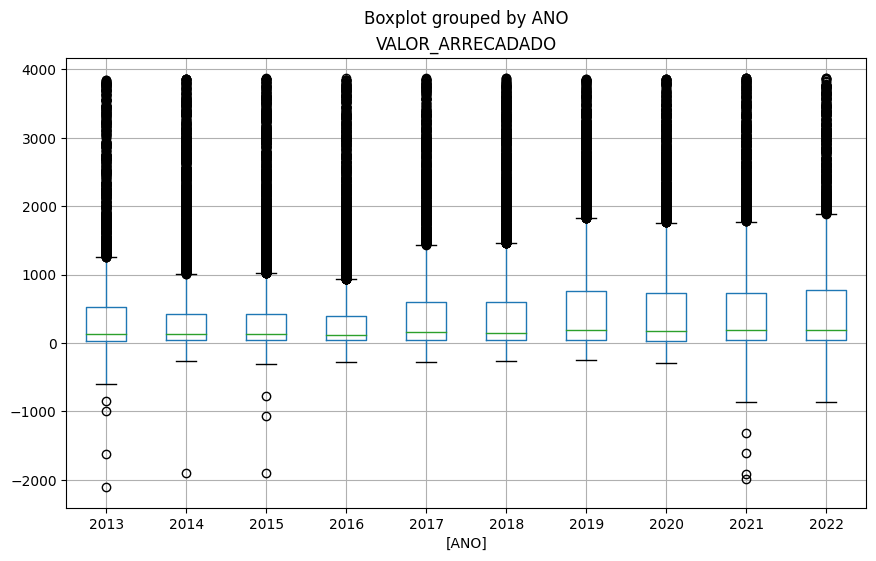

In [7]:
# aplicação de IQR - interquartile range
Q1 = dados_receitas['VALOR_ARRECADADO'].quantile(0.25)
Q3 = dados_receitas['VALOR_ARRECADADO'].quantile(0.75)
IQR = Q3 - Q1
print(f'Q1: {Q1}')
print(f'Q3: {Q3}')
print(f'IQR: {IQR}')

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR
print(f'Limite inferior: {limite_inferior}')
print(f'Limite superior: {limite_superior}')

df_sem_outliers = dados_receitas[(dados_receitas['VALOR_ARRECADADO'] >= limite_inferior) & (dados_receitas['VALOR_ARRECADADO'] <= limite_superior)]
df_sem_outliers = df_sem_outliers[['ANO', 'VALOR_ARRECADADO']]
print(f'Quantidade de registros sem outliers: {df_sem_outliers.shape[0]}')
df_sem_outliers.boxplot(by='ANO', figsize=(10, 6))

In [8]:
df_sem_outliers = dados_receitas[(dados_receitas['VALOR_ARRECADADO'] >= limite_inferior) & (dados_receitas['VALOR_ARRECADADO'] <= limite_superior)]

In [15]:
# Coluna pela qual você deseja amostrar proporcionalmente
coluna_amostragem = 'ANO'

# Porcentagem de amostras desejadas)
porcentagem_amostra = 0.5

# Divida o DataFrame em grupos com base na coluna de amostragem
grupos = df_sem_outliers.groupby(coluna_amostragem, group_keys=False, sort=False)

# Inicialize listas para armazenar os DataFrames de amostra e de não amostra
amostras = []
nao_amostras = []

# Para cada grupo, aplique o método sample com a porcentagem desejada
for nome_grupo, grupo in grupos:
    grupo_amostra = grupo.sample(frac=porcentagem_amostra)
    
    # Adicione o grupo de amostra à lista de amostras
    amostras.append(grupo_amostra)
    
    # Adicione o grupo de não amostra à lista de não amostras
    grupo_nao_amostra = grupo.drop(grupo_amostra.index)
    nao_amostras.append(grupo_nao_amostra)

# Crie um novo DataFrame contendo todas as amostras
df_amostrado = pd.concat(amostras)

# Crie um novo DataFrame contendo todos os dados que não entraram no sample
df_nao_amostrado = pd.concat(nao_amostras)

## Implementação do algoritmo de RNN

In [13]:
df_amostrado.head()

,COD_RECEITA,DATA,COD_CONTRIBUINTE,VALOR_ARRECADADO,FONTE_DADOS,COD_CONTRIBUINTE_INTEIRO,COD_FONTE_DADOS,ANO,MES,DIA
4207,1220990100,2013-09-16,4e28a296233913,130.00,prefeitura municipal,41,7667,2013,9,16
381,1325000002,2013-02-28,886cd0eabf5a18,546.87,prefeitura municipal,1,7667,2013,2,28
7230,1121310001,2013-05-21,470c93ab945237,240.00,sctrans,144,7669,2013,5,21
4655,1113050001,2013-11-28,2d027177369c9d,403.83,prefeitura municipal,122,7667,2013,11,28
5682,1113050001,2013-12-19,afd5f2c52e49b3,642.78,prefeitura municipal,2,7667,2013,12,19


<p> Para uma amostra de 5% do volume de dados =>
MSE: 600884.33 & MAE: 500.07
</p>
<p> Para uma amostra de 10% do volume de dados =>
MSE: 551810.79 & MAE: 551.64
</p>


In [16]:
# Divida os dados em recursos (X) e rótulos (y)
X = df_amostrado['ANO'].values.reshape(-1, 1)
y = df_amostrado['VALOR_ARRECADADO'].values

# Normalização dos dados (escala entre 0 e 1)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.reshape(-1, 1))

# Divida os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crie o modelo RNN
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Treine o modelo
model.fit(X_train, y_train, epochs=100, batch_size=1)

# Faça previsões
y_pred = model.predict(X_test)

# Inverta a escala das previsões para obter valores reais
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

# Avalie o desempenho do modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'MSE: {mse:.2f}')
print(f'MAE: {mae:.2f}')

Epoch 1/100
33493/33493 [==============================] - 81s 2ms/step - loss: 0.0169
Epoch 2/100
33493/33493 [==============================] - 82s 2ms/step - loss: 0.0165
Epoch 3/100
33493/33493 [==============================] - 97s 3ms/step - loss: 0.0165
Epoch 4/100
33493/33493 [==============================] - 81s 2ms/step - loss: 0.0164
Epoch 5/100
33493/33493 [==============================] - 80s 2ms/step - loss: 0.0164
Epoch 6/100
33493/33493 [==============================] - 85s 3ms/step - loss: 0.0164
Epoch 7/100
33493/33493 [==============================] - 80s 2ms/step - loss: 0.0164
Epoch 8/100
33493/33493 [==============================] - 86s 3ms/step - loss: 0.0164
Epoch 9/100
33493/33493 [==============================] - 88s 3ms/step - loss: 0.0164
Epoch 10/100
33493/33493 [==============================] - 87s 3ms/step - loss: 0.0164
Epoch 11/100
33493/33493 [==============================] - 93s 3ms/step - loss: 0.0164
Epoch 12/100
 9684/33493 [=======>.......

KeyboardInterrupt: 